In [67]:
import random
import numpy as np
import statistics 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from scipy import ndimage
from scipy import stats
from scipy.spatial import distance
from scipy.stats.stats import pearsonr 
import scipy.signal 
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from sklearn import preprocessing
from itertools import cycle
import seaborn as sns
import math
from sklearn.model_selection import train_test_split

import matlab
import matlab.engine

#plotting params
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = '0.5'
mpl.rcParams['axes.labelsize'] = '8'
mpl.rcParams['axes.labelcolor'] = 'black'

mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['xtick.labelsize'] = '8'
mpl.rcParams['ytick.labelsize'] = '8'
mpl.rcParams['ytick.color'] = 'black'

In [68]:
animals = ['F', 'L', 'I']
for i in animals:
    insert_animal = i

    inputEventTrace = '/Users/rufusmitchell-heggs/Desktop/data/preprocessing/AN'+insert_animal+'/preprocessed_files/AN'+insert_animal+'mega_events.csv'
    inputTrace = '/Users/rufusmitchell-heggs/Desktop/data/preprocessing/AN'+insert_animal+'/preprocessed_files/AN'+insert_animal+'mega_trace.csv'


    data_event = pd.read_csv(inputEventTrace, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
    data_trace = pd.read_csv(inputTrace, sep=',', dtype=str, error_bad_lines=False, encoding="utf-8-sig")
    data_trace['unique_stage']=data_trace['stage']+data_trace['session'].astype(str)

    def get_session(data_event_or_data_trace):
        """"get session takes the mega_event or trace file in and returns a list of all the session blocks
        INPUT:
        -------
        >> data_event_or_data_trace - mega_events OR mega_trace file

        OUTPUT:
        -------
        >> blocks - a list of all events or traces as in dataframe format """

        batches_dic = {'Exp1':1, 'Pre1':2, 'Nov1':3, 'Exp2':4, 'Pre2':5, 'Nov2':6, 'Exp3':7, 'Nov3':8}
        batches = list(set(data_event_or_data_trace.unique_stage))
        sorted_batches = []
        for i in batches:
            sorted_batches.append(batches_dic[i])
        sorted_batches.sort()

        batches = []
        for i in sorted_batches:
            batches.append(list(batches_dic.keys())[list(batches_dic.values()).index(i)])

        blocks = []
        for batch in batches:
            blocks.append(data_event_or_data_trace[data_event_or_data_trace['unique_stage']==batch])

        return blocks

    traces = get_session(data_trace)
    events = get_session(data_event)

    events = [events[1], events[2], events[4], events[5], events[7]]
    traces = [traces[1], traces[2], traces[4], traces[5], traces[7]]
    
    for i in range(len(events)):

        sesh = i
        if insert_animal == 'F' or insert_animal == 'I':
            if i == 1 or i == 3 or i == 4:
                stranger = 'both'
            else:
                stranger = 2
        else:
            if i == 1 or i == 3 or i == 4:
                stranger = 'both'
            else:
                stranger = 1    

    ## --------------------------------------------------------------------------------------------------
        traces_session = traces[sesh]
        events_session = events[sesh]
        print(np.array(traces_session['unique_stage'])[0])
        animal_cell_count = {'F':238, 'I':126, 'L':74}
        all_cells = traces_session.iloc[: , 2:animal_cell_count[insert_animal]] #<---- (ANF - 238 cells, ANI - 126 cells, ANL - 74 cells)
        cells_dictionary = traces_session.iloc[: , 2:animal_cell_count[insert_animal]].loc[:,~(traces_session==" nan").any()].columns.values
        nan_cells = (set(all_cells.columns.values).difference(cells_dictionary))

        data_trace = np.array(traces_session[cells_dictionary].astype(float)).transpose()
        data_events=np.array(events_session[cells_dictionary].astype(float)).transpose()
        data_events_normalized = normalize(data_events, axis=1)

        behav_vector = np.array(traces_session['raw_behaviour'].astype(float))

        cage = stranger
        behav_vec_cropped = []
        for i in behav_vector:
            if cage == 2:
                if i == 2:
                    behav_vec_cropped.append(1)
                elif i == 1:
                    behav_vec_cropped.append(0)
                else:
                    behav_vec_cropped.append(0) 
            elif cage == 1:
                if i == 2:
                    behav_vec_cropped.append(0)
                elif i == 1:
                    behav_vec_cropped.append(1)
                else:
                    behav_vec_cropped.append(0) 
            elif cage == 'both':
                if i > 0:
                    behav_vec_cropped.append(1)
                else:
                    behav_vec_cropped.append(0) 

        behav_vector = np.array(behav_vec_cropped)

        def event_categorization(event_trace, bin_size = 0.25):
            """"Categorize all event traces into different bins of spike amplitudes.
            Due to low resolution, we can account for any lost spikes and weight events accordingly"""
            bin_size = bin_size #<---- must be greater than 0.25
            all_events = []
            data_events_categorised = []
            for neuron in range(len(event_trace)):
                neuron_events_categorised = []
                for event in event_trace[neuron]:
                    if event > 0:
                        if event < bin_size:
                            neuron_events_categorised.append(1)
                        elif bin_size < event < (bin_size*2):
                            neuron_events_categorised.append(2)
                        elif (bin_size*2) < event < (bin_size*3):
                            neuron_events_categorised.append(3)
                        elif (bin_size*3) < event :
                            neuron_events_categorised.append(4)
                    else:
                        neuron_events_categorised.append(0)         
                data_events_categorised.append(neuron_events_categorised)
            return data_events_categorised

        def spike_binning(spike_array, bin_size=4):
            bin_size = bin_size
            binned_spikes = []
            for neuron in spike_array:
                per_neuron=[]
                i=0
                while i <= len(neuron):
                    per_neuron.append(sum(neuron[i:i+bin_size]))
                    i+=bin_size
                binned_spikes.append(per_neuron)
            return binned_spikes

        def behav_vector_binning(behav_vector, bin_size=4):
            bin_size = bin_size
            binned_behav_vector = []
            i=0
            while i <= len(behav_vector):
                binned_behav_vector.append(stats.mode(behav_vector[i:i+bin_size])[0])
                i+=bin_size
            return binned_behav_vector

        data_events_categorised = event_categorization(data_events_normalized, bin_size = 0.25)
        binned_data_events_categorised = np.array(spike_binning(data_events_categorised))
        binned_behav_vector = np.array(np.array(behav_vector_binning(behav_vector)).transpose().tolist()[0])

        empty = []
        empty_binary = []
        for i in range(len(binned_data_events_categorised)):
            if sum(binned_data_events_categorised[i]) == 0:
                empty.append(i)

        binned_data_events_categorised = np.delete(binned_data_events_categorised, empty, 0).transpose()
        cells_dictionary = np.delete(cells_dictionary, empty, 0)
        binned_data_events_categorised = binned_data_events_categorised.transpose()
        num_frames = num_frames = len(binned_behav_vector)
        
        def mutualinfo_cell_stim(binned_behav_vector, binned_data_events_categorised):
            """CELL STIMULUS MUTUAL INFORMATION calculated using behavioual vector
            and the binned data events"""
            #Probability of each behaviour occuring
            count_dic = {}
            for behaviour in binned_behav_vector:
                #Number of spikes of different amplitude during different behaviours
                count_entry = str(int(behaviour))
                if count_entry in count_dic:
                    count_dic[count_entry] += 1
                else:
                    count_dic[count_entry] = 1  
            probability_dic ={}
            for key in count_dic:
                probability_dic[key] = count_dic[key]/sum(count_dic.values())

            mi_r_cat = []
            probability_dic_all = {}
            for neuron in range(len(binned_data_events_categorised)): 
                #Define probability of each neuron firing
                count_individ_dic = {0:0, 1:0}
                for spike in binned_data_events_categorised[neuron]:
                    spike_count_entry = int(spike)
                    if spike_count_entry > 0:
                        count_individ_dic[1] += spike*1
                    else:
                        count_individ_dic[0] += 1 

                probability_response_dic = {}
                for key in count_individ_dic:
                    probability_response_dic[key] = count_individ_dic[key]/sum(count_dic.values())

                #define entropy for every neuron
                entropyr = 0
                for key in probability_response_dic:
                    entropyr += -(probability_response_dic[key]*math.log2(probability_response_dic[key]))

                #intialise count__spike_behav_dic
                count__spike_behav_dic = {}
                for key in count_dic:
                    count__spike_behav_dic['0'+key]=0
                    count__spike_behav_dic['1'+key]=0    

                #How many spikes are there during each behaviour
                for spike, behaviour in zip(binned_data_events_categorised[neuron], binned_behav_vector):
                    count_entry = str(int(spike))+str(int(behaviour))
                    if int(count_entry[0]) > 0:
                        count_entry = str(1)+str(int(behaviour))
                        count__spike_behav_dic[count_entry] += spike*1
                    else:
                        count__spike_behav_dic[count_entry] += 1

                #What is the probability of that spike during the behaviour
                probability_spike_behav_dic = {}         
                for key in count__spike_behav_dic:
                    probability_spike_behav_dic[key] = count__spike_behav_dic[key]/sum(count_dic.values())

                cond_entropy_dic = {'0':0, '1':0, '2':0}
                cond_ent =0
                for key in probability_spike_behav_dic:
                    if  probability_spike_behav_dic[key] > 0:
                        cond_entropy_dic[key[1]] += probability_spike_behav_dic[key]*math.log2(probability_dic[key[1]]/probability_spike_behav_dic[key])
                        cond_ent += probability_spike_behav_dic[key]*math.log2(probability_dic[key[1]]/probability_spike_behav_dic[key])

                mi_resbehav = entropyr - cond_ent
                mi_r_cat.append(mi_resbehav)

            total_categorised_info = sum(mi_r_cat)
            return mi_r_cat

        def behav_vectors(behavioral_vector):
            """ 
            Create a new matrix that replaces sequences of ones 
            with the length of the sequence of ones

            INPUT:
            -------
            >> behavioral_vector - the original behavioral vector

            OUTPUT:
            -------
            >> behav_vectors - adpated behavioral vector (e.g. 001100111 --> 002003)
            """
            behav_vectors = []
            for i in range(len(behavioral_vector)):
                if i > 0:
                    if behavioral_vector[i] > 0 and behavioral_vector[i-1] == 0:
                        count = 0
                        idx = 0
                        while behavioral_vector[i+idx] != 0 in behavioral_vector[i:]:
                            idx +=1
                            count +=1
                        behav_vectors.append(count)
                    elif behavioral_vector[i] !=1 :
                        behav_vectors.append(behavioral_vector[i])
                elif behavioral_vector[i] != 1:
                    behav_vectors.append(behavioral_vector[i])
            return behav_vectors

        def shuffled_vector_scores(behavioral_vector, calcium_traces, shuffles = 5000):
            """ 
            Creates n shuffles of the behavioral vector and calculates the new similarity 
            score between behavioral vectors and calcium trace vectors
            INPUT:
            -------
            >> behavioral_vector -  use behav_vectors func
            >> calcium_traces - (raw calcium trace for each file)
            >> shuffles - the number of times to shuffle the data (default = 5000)

            OUTPUT:
            -------
            >> similarity_shuffled_all - Similarity score for calcium trace vectors and shuffled behavioral vector
            >> similarity_calcium_traces - Shuffled behavioral vectors (as a list)
            """
            similarity_shuffled_all = []
            new_seq_all = []
            for i in range(shuffles):
                np.random.shuffle(behavioral_vector)

                indexes = []
                num_ones = []
                behav_vector_all = np.zeros(num_frames)
                for vector in range(len(behavioral_vector)):
                    if behavioral_vector[vector] > 0:
                        indexes.append(np.arange(vector, vector+behavioral_vector[vector],1))
                        num_ones.append(np.ones(behavioral_vector[vector]))            
                indexes = np.array(np.concatenate(indexes).ravel().tolist())
                num_ones = np.array(np.concatenate(num_ones).ravel().tolist())
                behav_vector_all[indexes] = num_ones
                new_seq_all.append(behav_vector_all)
                similarity_shuffled_all.append(mutualinfo_cell_stim(behav_vector_all, binned_data_events_categorised))  
                if i%1000 ==0 :
                    print('iteration =',i)
            return similarity_shuffled_all, new_seq_all

        def percentile(similarity_shuffled_all, similarity_calcium_traces):
            """ 
            Calculates the percentile of the calcium trace vector similarity score
            INPUT:
            -------
            >> similarity_shuffled_all -  use shuffled_vector_scores function
            >> similarity_calcium_traces - use similarity_calc

            OUTPUT:
            -------
            >> percentile - percentile out of shuffled dsimilarity score distribution
            >> similarity_distribution_all - similarity score distribution for all behav_vectors
            """
            similarity_distribution_all = []
            percentile = []
            for i in range(len(similarity_shuffled_all[0])):
                similarity_distribution = []
                for j in range(len(similarity_shuffled_all)):
                    similarity_distribution.append(similarity_shuffled_all[j][i])
                percentile.append(stats.percentileofscore(similarity_distribution, similarity_calcium_traces[i]))
                similarity_distribution_all.append(similarity_distribution)
            return [percentile, similarity_distribution_all]

        similarity = np.array(mutualinfo_cell_stim(binned_behav_vector, binned_data_events_categorised))
        perc, dist = percentile(shuffled_vector_scores(behav_vectors(binned_behav_vector), binned_data_events_categorised, shuffles=5000)[0], similarity)

        on_off = []
        for i in range(len(perc)):
            if perc[i] >= 99.17:
                on_off.append(i)
        on = []
        off = []
        for neuron in on_off:
            on_count = 0
            off_count = 0
            for response, behaviour in zip(binned_data_events_categorised[neuron], binned_behav_vector):
                if behaviour > 0 and response > 0:
                    on_count+=1
                elif behaviour == 0 and response > 0:
                    off_count+=1
            if on_count/(on_count+off_count) >= 0.7 and on_count > 3:
                on.append(neuron)
            elif off_count/(on_count+off_count) >= 0.7 and off_count > 3:
                off.append(neuron)

        on_cells = list(cells_dictionary[on])
        off_cells = list(cells_dictionary[off])

        if len(on_cells) < 30:
            while len(on_cells) < 30:
                on_cells.append(0)
        if len(off_cells) < 30:
            while len(off_cells) < 30:
                off_cells.append(0)

        csvfile = pd.read_csv(inputTrace[:-17]+'onoff.csv')
        csvfile[traces_session['unique_stage'].iloc[1]+'on']= on_cells
        csvfile[traces_session['unique_stage'].iloc[1]+'off']= off_cells
        csvfile.to_csv(inputTrace[:-17]+'onoff.csv')


on_count= 12 off count = 5


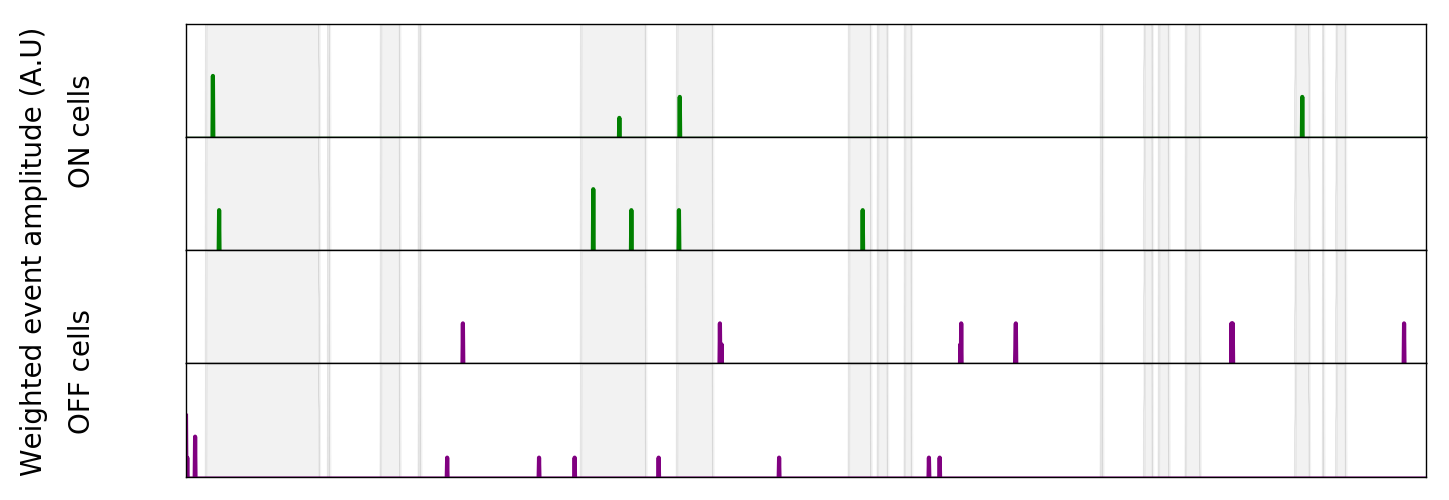

In [23]:
# time = np.arange(0, len(binned_behav_vector)-(0.05006*4)*(0.05006*4), 1)
# print('on_count=', len(on), 'off count =', len(off))

# fig, axs = plt.subplots(4, 1, figsize=(8,3), dpi=200, facecolor='w', edgecolor='k')
# gs = gridspec.GridSpec(4, 1, height_ratios=[1,1,1,1]) 

# binned_behav_vector1 = [x * 5.5 for x in binned_behav_vector]

# axs[0] = plt.subplot(gs[0])
# axs[0].plot(time, binned_data_events_categorised[on[0]], color = 'green')
# axs[0].plot(time, binned_behav_vector1,linewidth=0.02, color = 'black')
# axs[0].fill_between(time, 0, binned_behav_vector1, color='black', alpha = 0.05 )
# # axs[0].patch.set_facecolor('blue')
# # axs[0].patch.set_alpha(0.05)
# axs[0].set_xlim(0, max(time))
# axs[0].set_ylim(0.1,5.5)
# axs[0]=plt.tick_params(bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

# axs[1] = plt.subplot(gs[1])
# axs[1].plot(time, binned_data_events_categorised[on[1]], color = 'green')
# axs[1].plot(time, binned_behav_vector1,linewidth=0.02, color = 'black')
# axs[1].fill_between(time, 0, binned_behav_vector1, color='black', alpha = 0.05 )
# # axs[1].patch.set_facecolor('blue')
# # axs[1].patch.set_alpha(0.05)
# axs[1].set_xlim(0, max(time))
# axs[1].set_ylim(0.1,5.5)
# axs[1]=plt.tick_params(bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

# axs[2] = plt.subplot(gs[2])
# axs[2].plot(time, binned_data_events_categorised[off[0]], color = 'purple')
# axs[2].plot(time, binned_behav_vector1,linewidth=0.02, color = 'black')
# axs[2].fill_between(time, 0, binned_behav_vector1, color='black', alpha = 0.05 )
# # axs[2].patch.set_facecolor('red')
# # axs[2].patch.set_alpha(0.05)
# axs[2].set_xlim(0, max(time))
# axs[2].set_ylim(0.1,5.5)
# axs[2]=plt.tick_params(bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

# axs[3] = plt.subplot(gs[3])
# axs[3].plot(time, binned_data_events_categorised[off[1]], color = 'purple')
# axs[3].plot(time, binned_behav_vector1,linewidth=0.02, color = 'black')
# axs[3].fill_between(time, 0, binned_behav_vector1, color='black', alpha = 0.05 )
# # axs[3].patch.set_facecolor('red')
# # axs[3].patch.set_alpha(0.05)
# axs[3].set_xlim(0, max(time))
# axs[3].set_ylim(0.1,5.5)
# axs[3]=plt.tick_params(bottom=False, left=False, right=False, labelleft=False, labelbottom=False)

# fig.text(0.03, 0.5,r"Weighted event amplitude (A.U)", ha='center', va='center', rotation='vertical')
# fig.text(0.06, 0.7,"ON cells", ha='center', va='center', rotation='vertical')
# fig.text(0.06, 0.3,"OFF cells", ha='center', va='center', rotation='vertical')

# plt.subplots_adjust(wspace=0, hspace=0)
# # plt.xlabel("Time (s)")

0


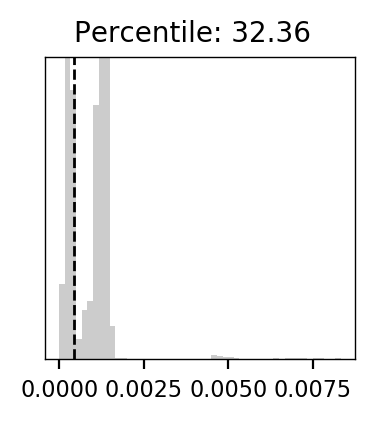

1


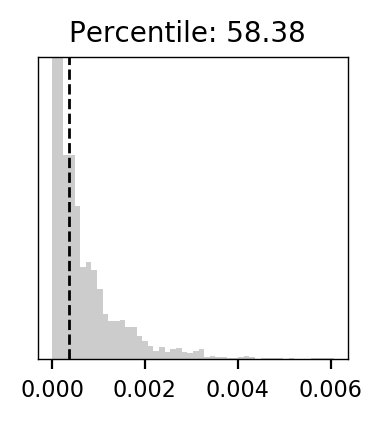

3


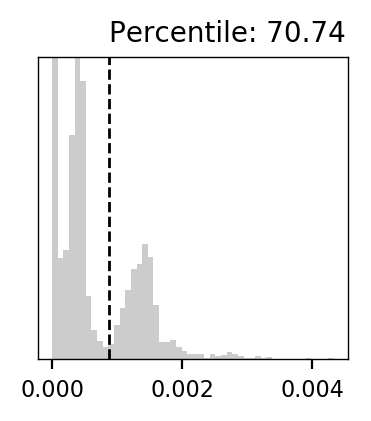

4


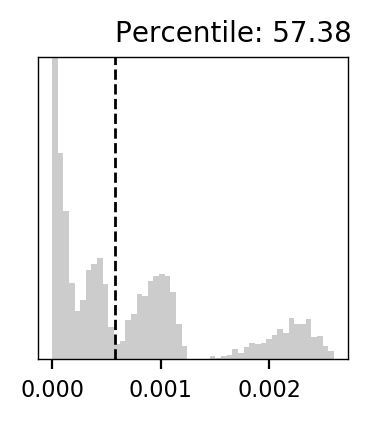

5


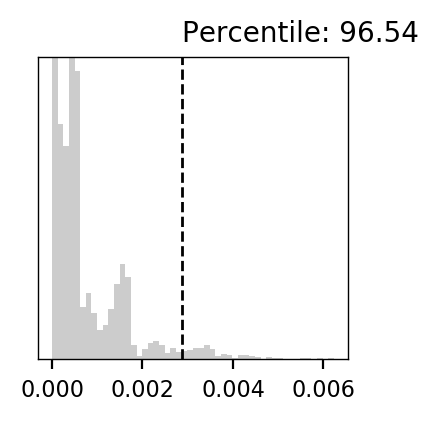

6


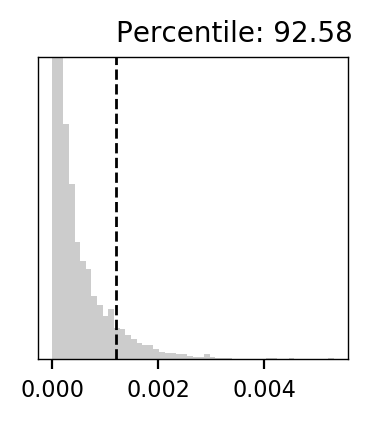

8


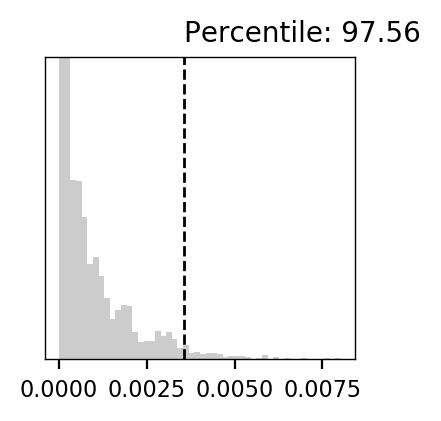

9


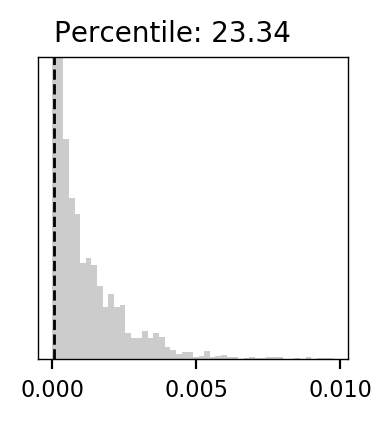

10


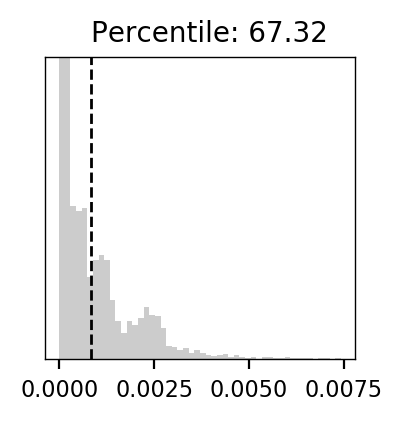

11


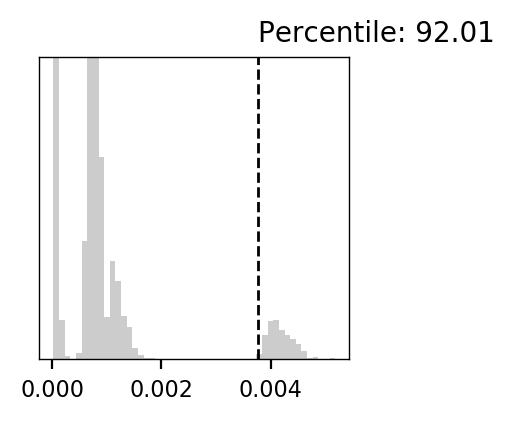

12


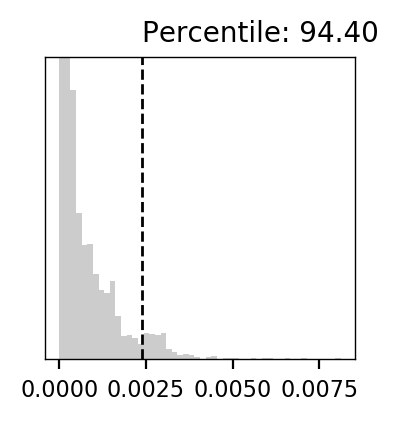

13


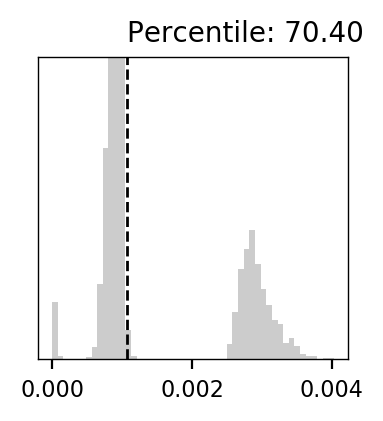

14


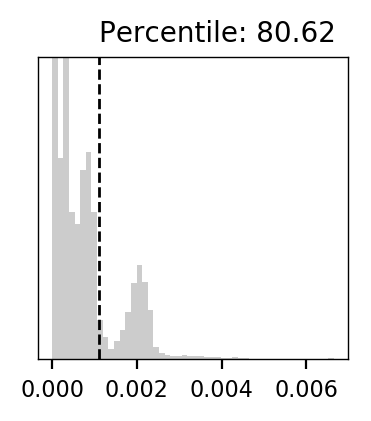

15


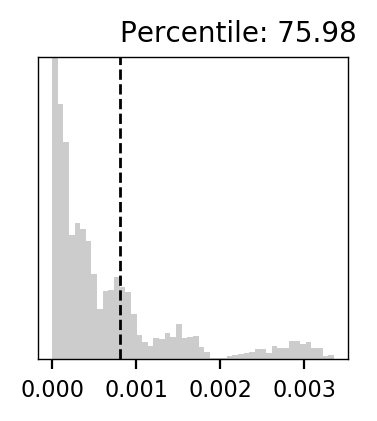

16


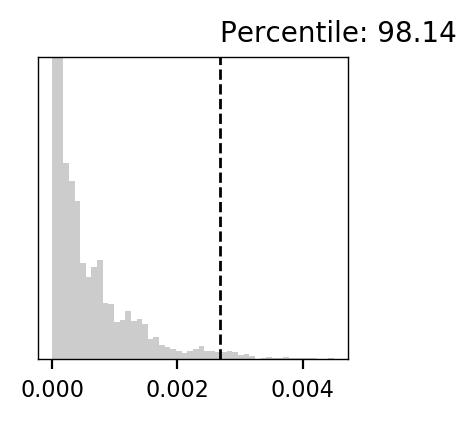

17


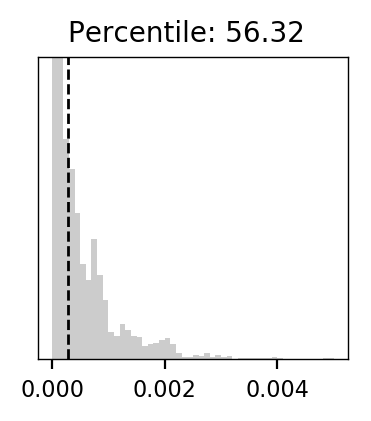

18


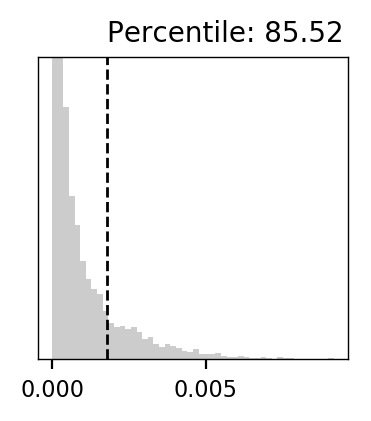

19


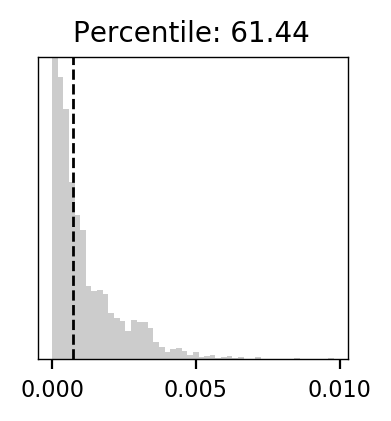

20


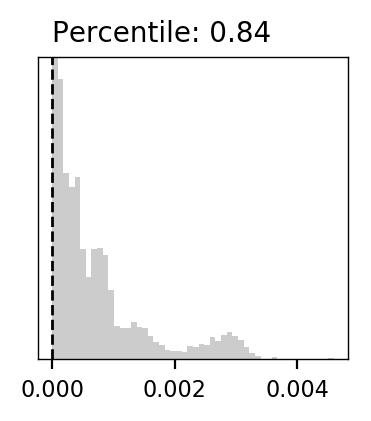

21


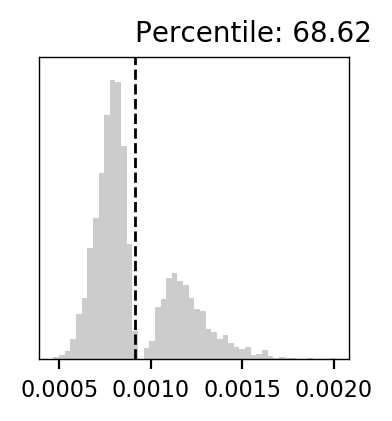

23


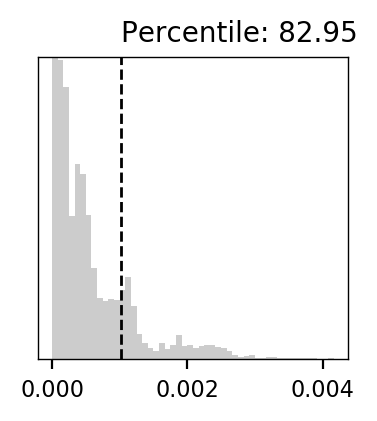

24


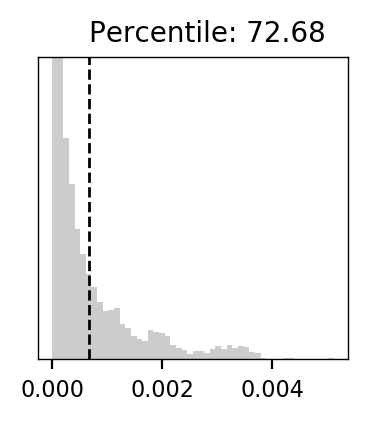

26


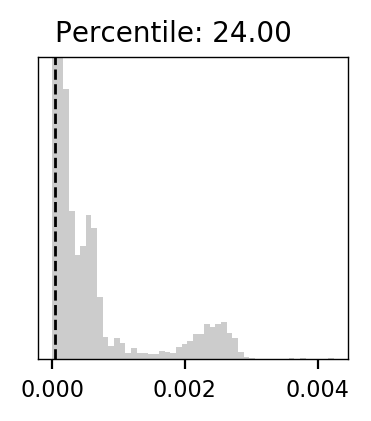

28


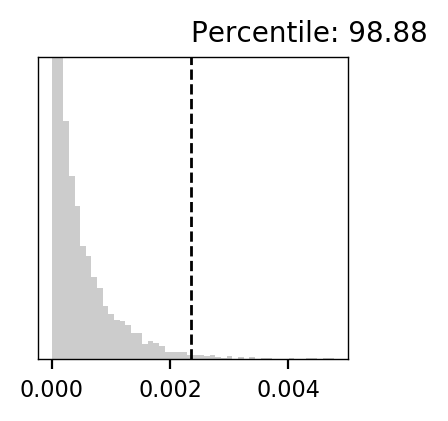

29


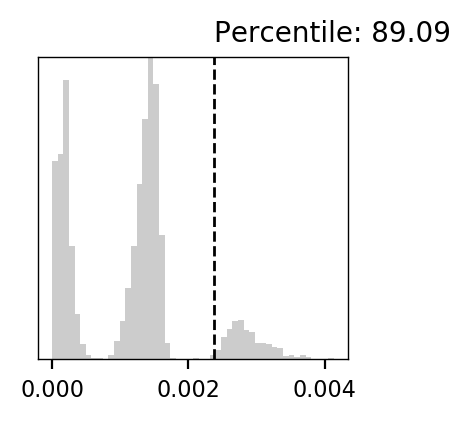

30


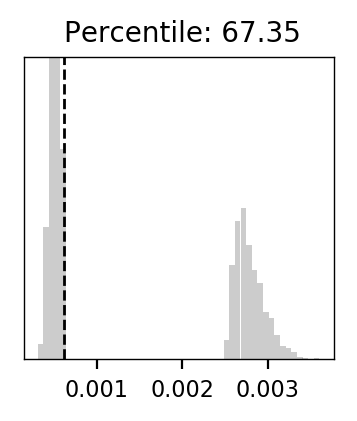

32


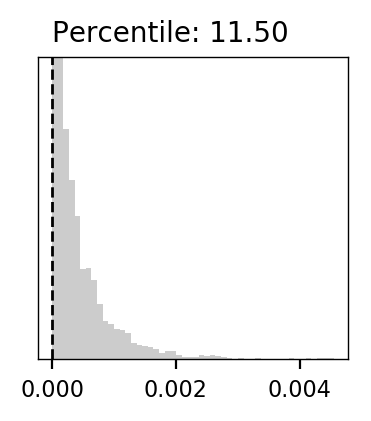

33


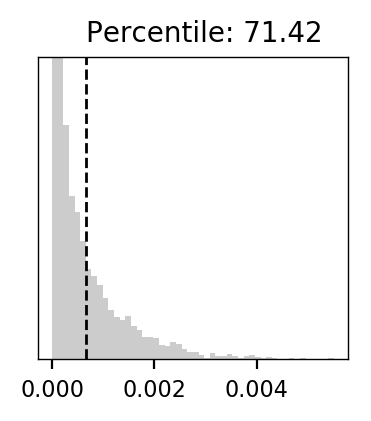

34


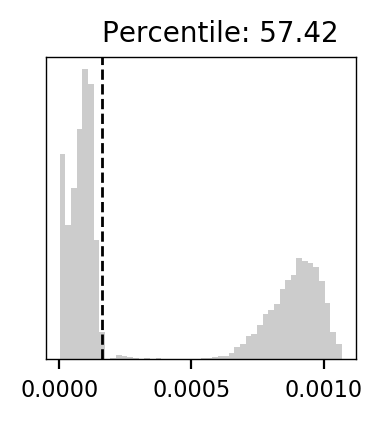

35


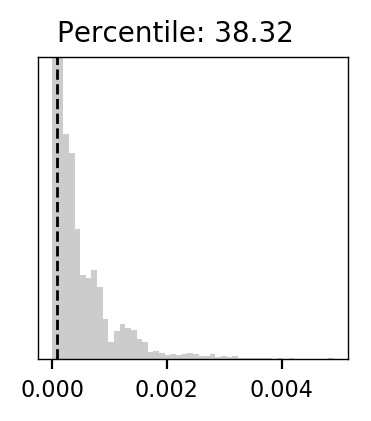

36


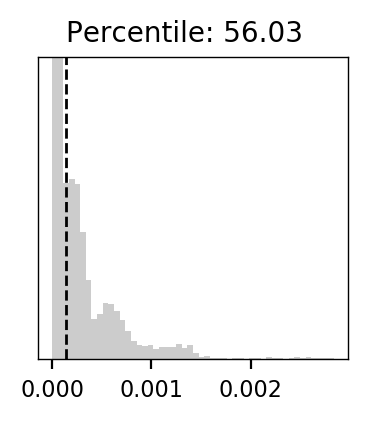

37


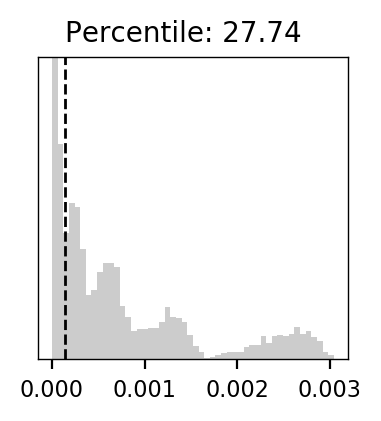

38


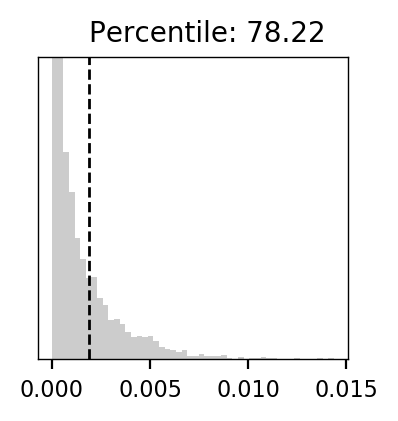

40


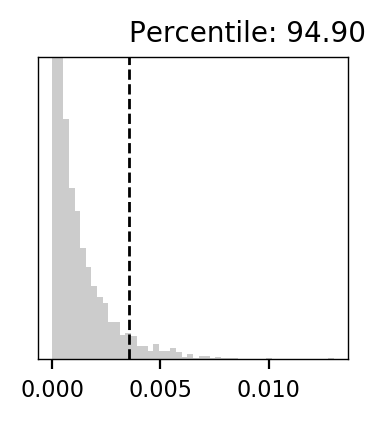

41


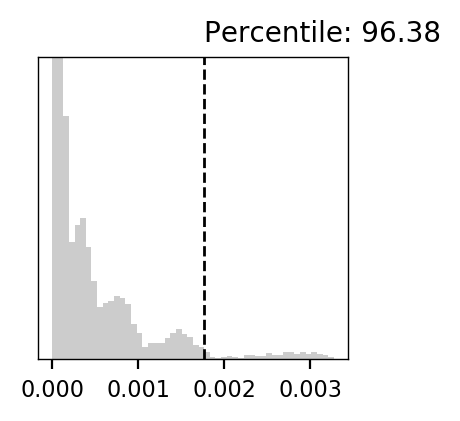

42


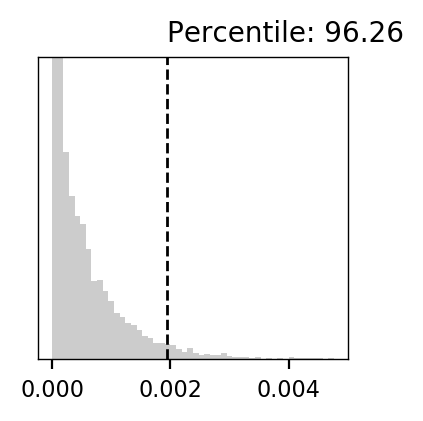

43


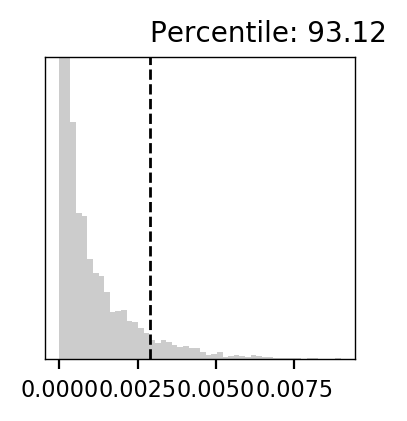

45


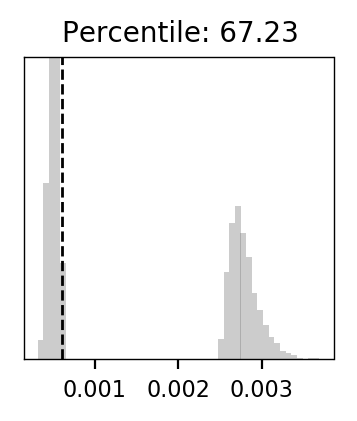

46


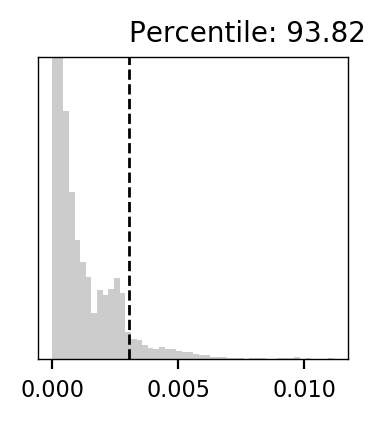

47


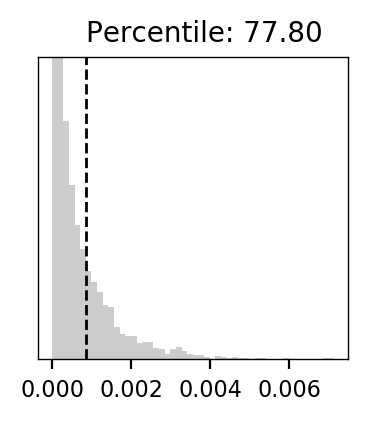

48


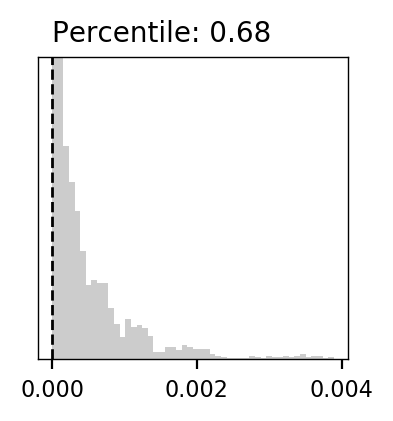

50


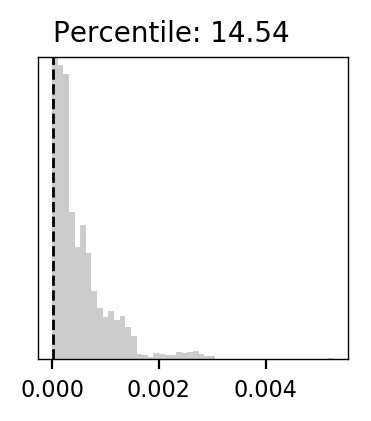

51


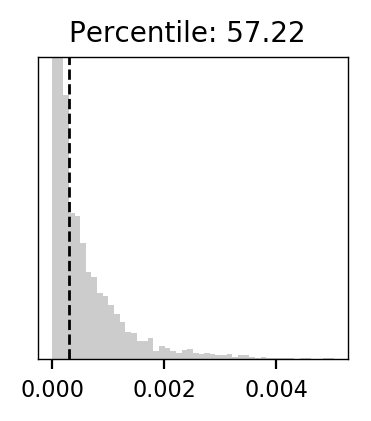

52


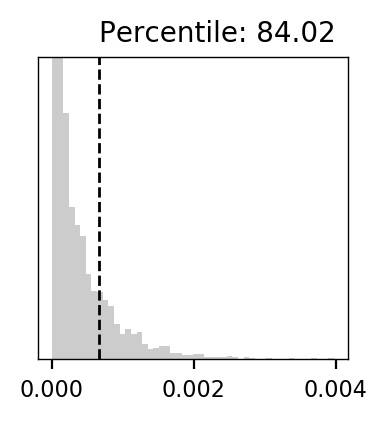

53


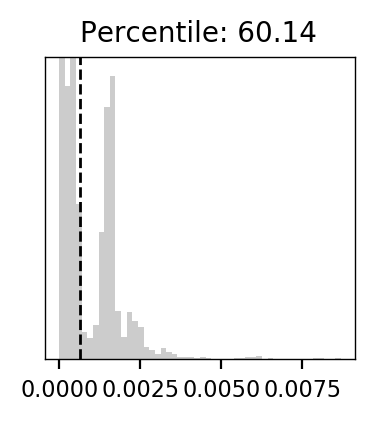

54


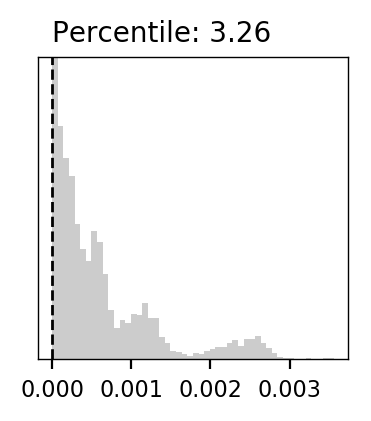

55


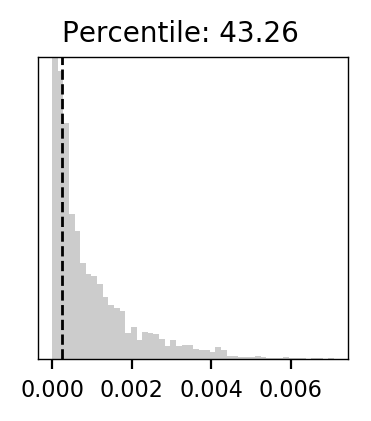

56


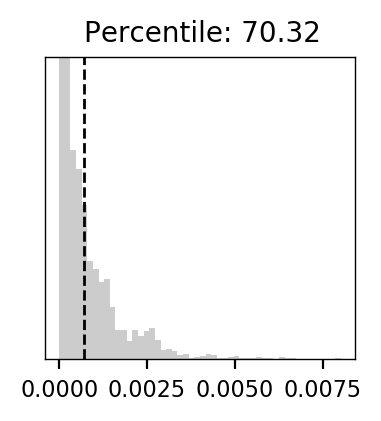

57


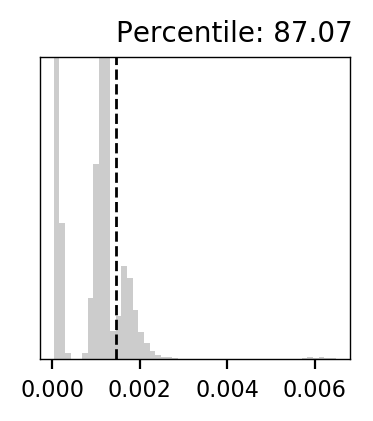

58


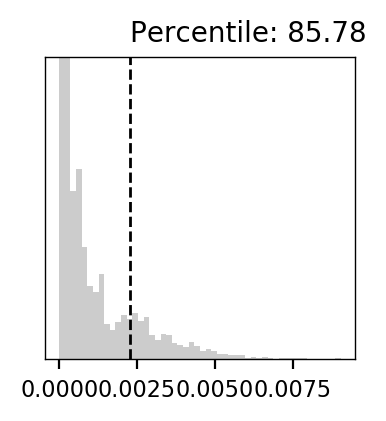

59


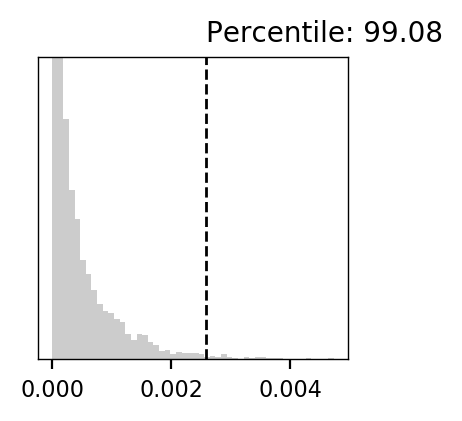

60


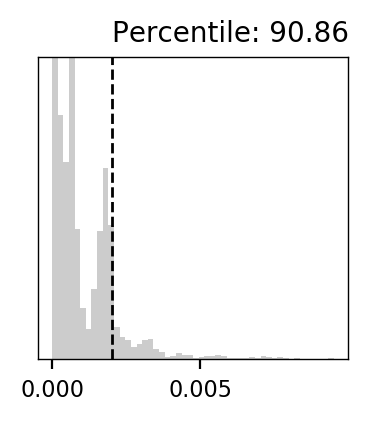

61


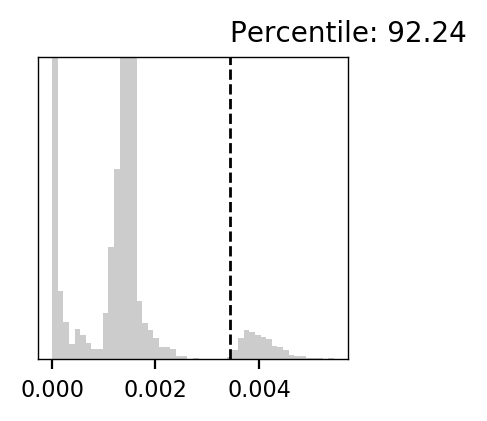

63


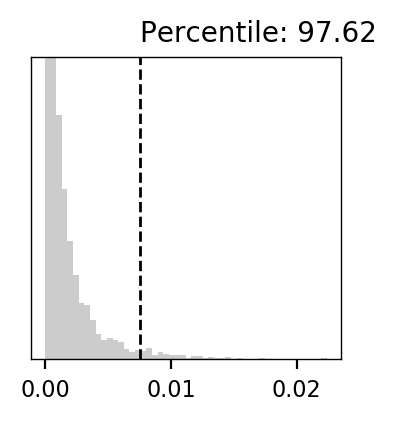

64


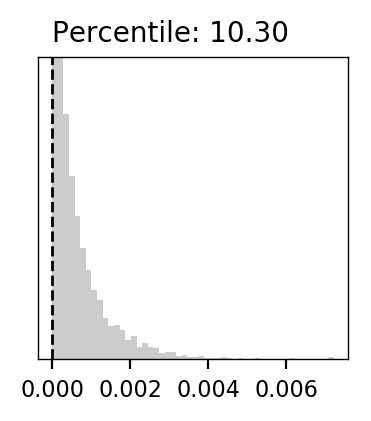

66


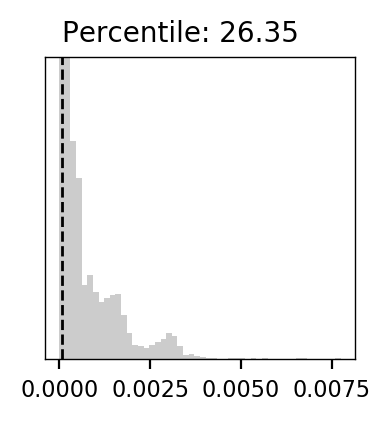

67


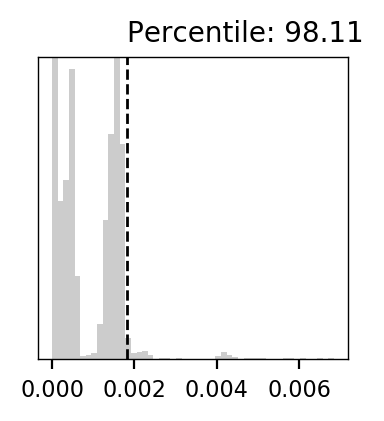

68


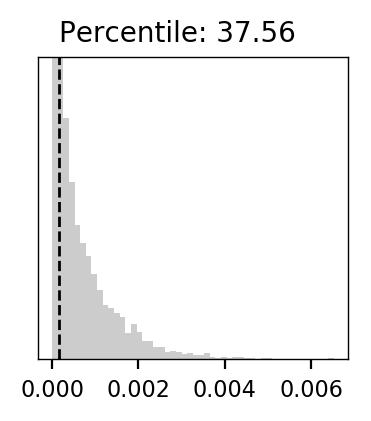

69


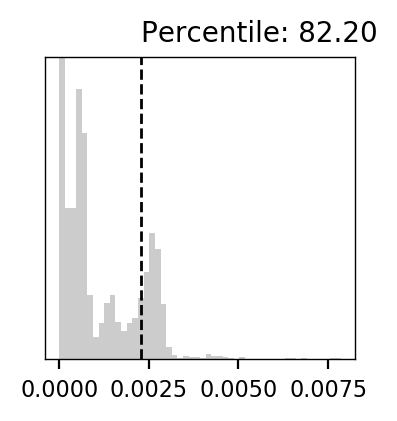

70


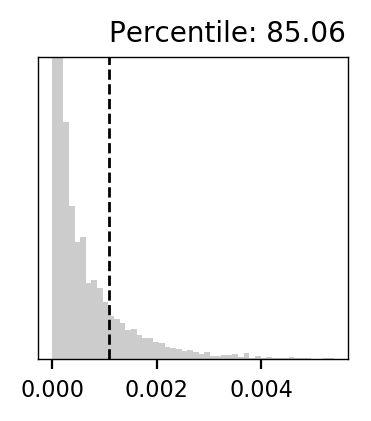

71


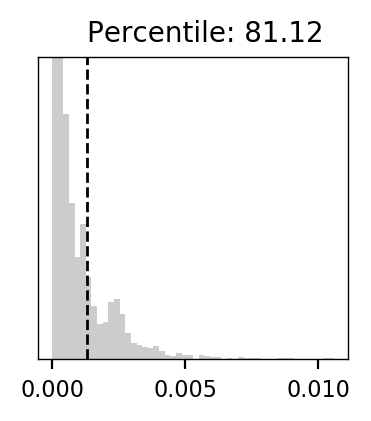

72


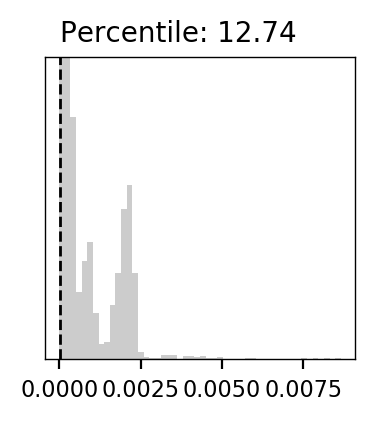

74


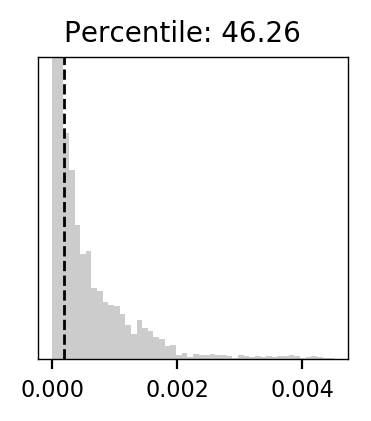

79


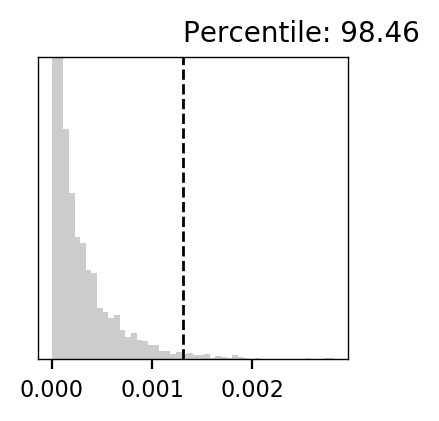

80


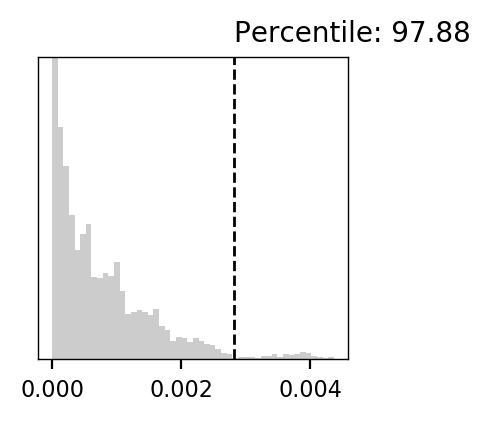

82


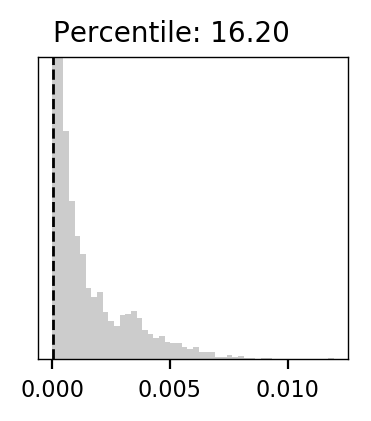

83


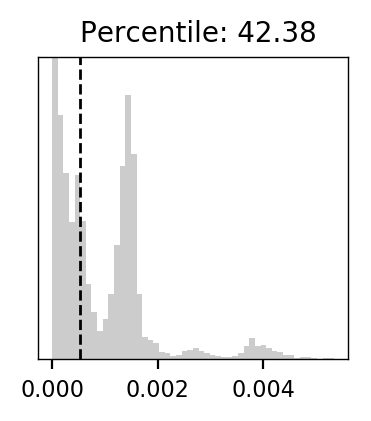

84


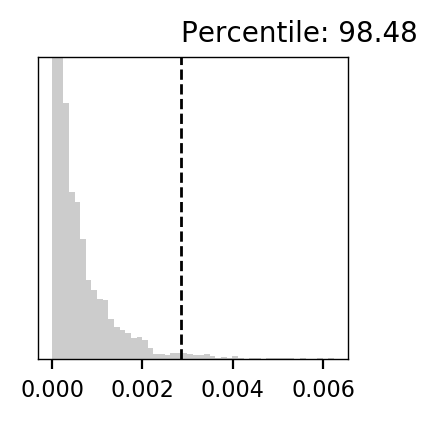

85


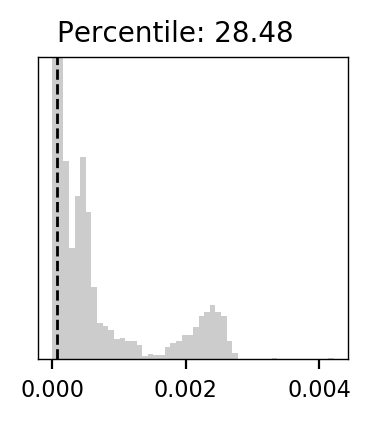

86


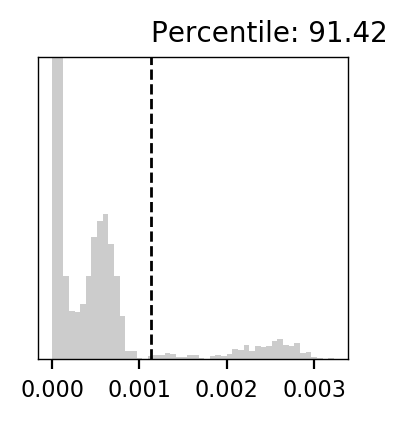

87


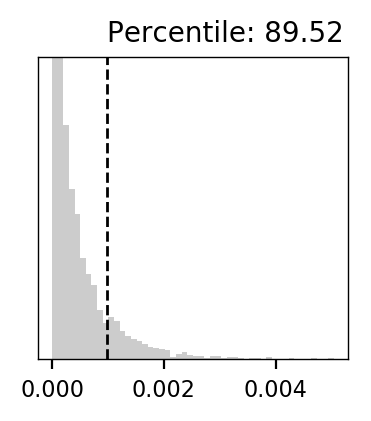

88


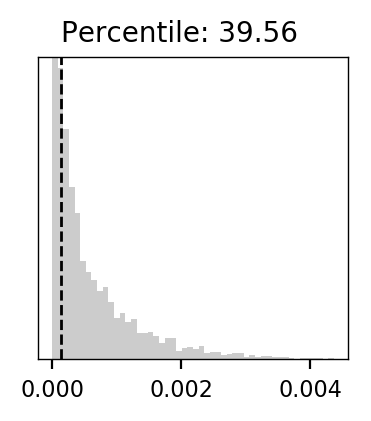

89


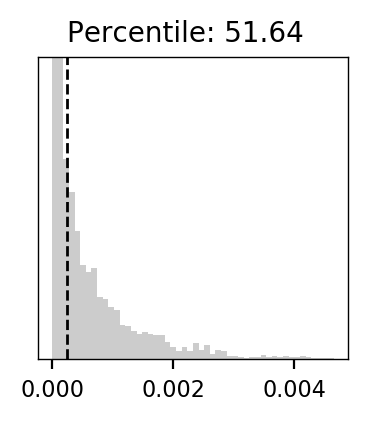

91


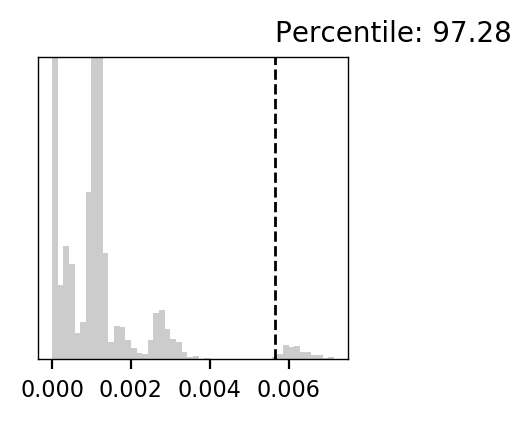

92


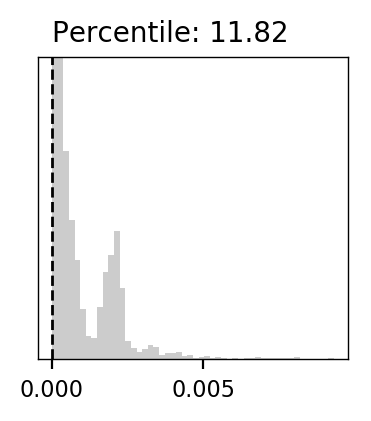

93


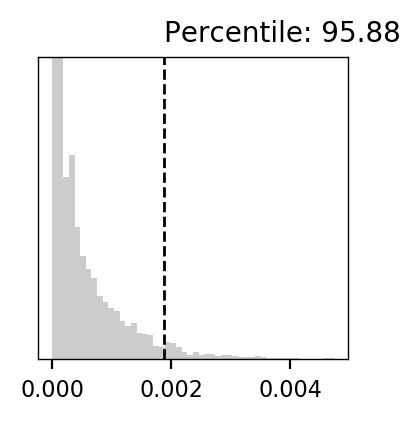

94


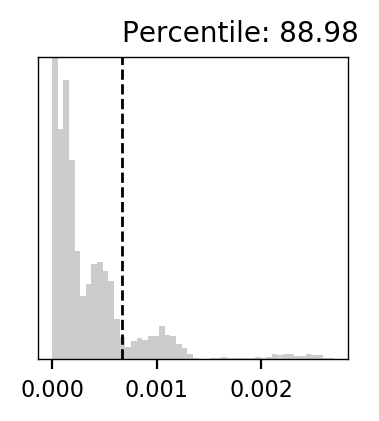

95


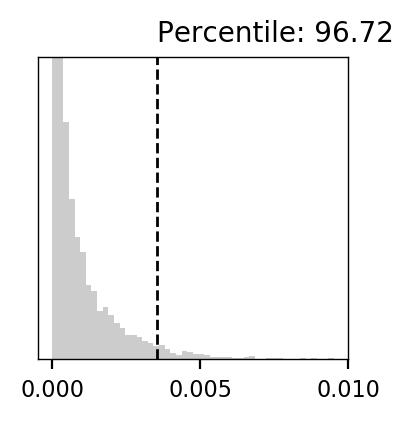

96


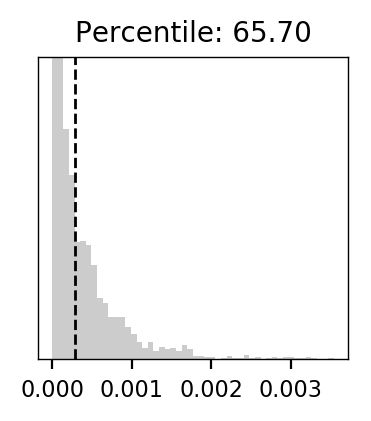

97


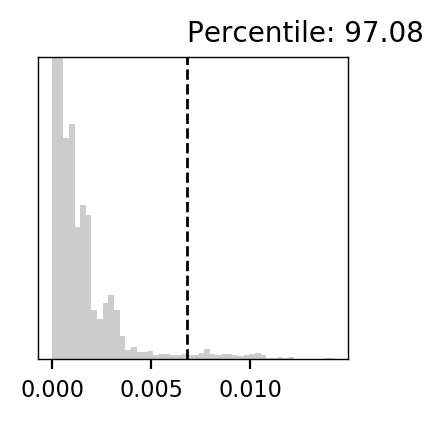

98


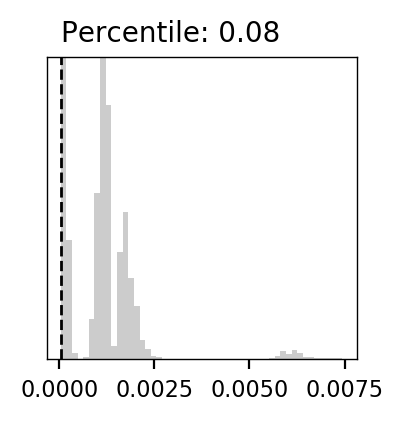

99


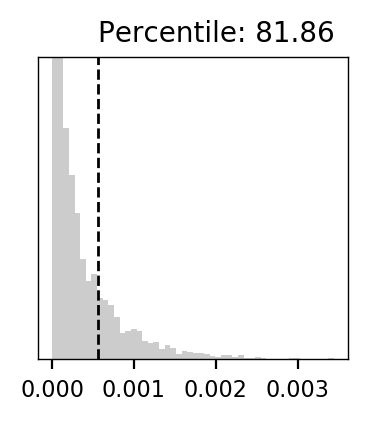

101


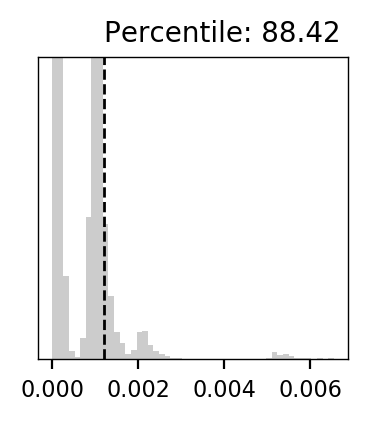

103


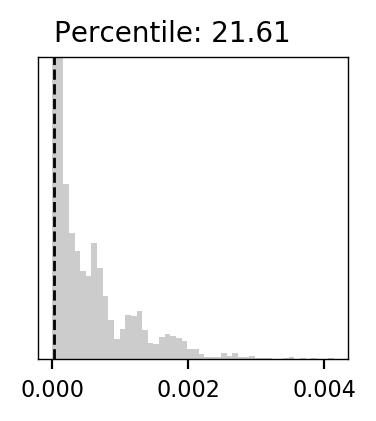

104


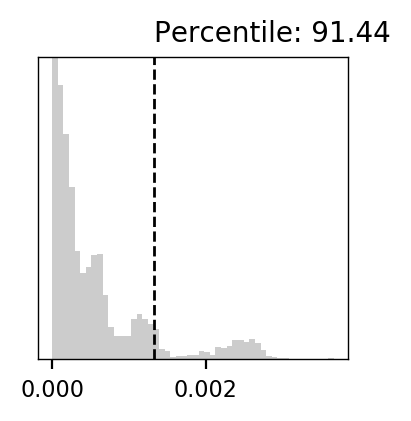

105


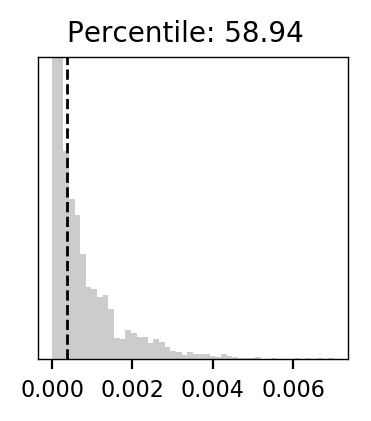

106


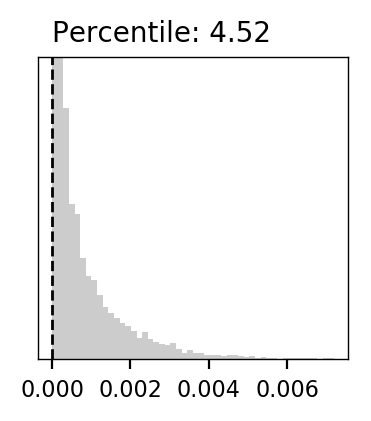

109


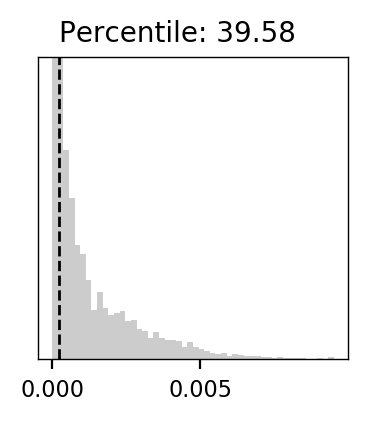

110


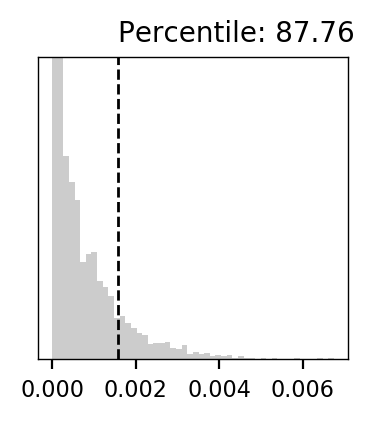

112


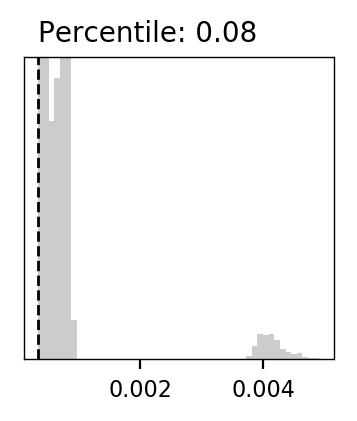

113


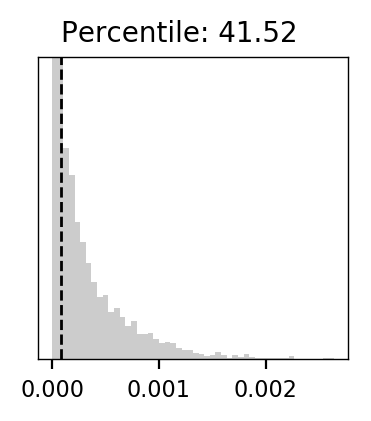

114


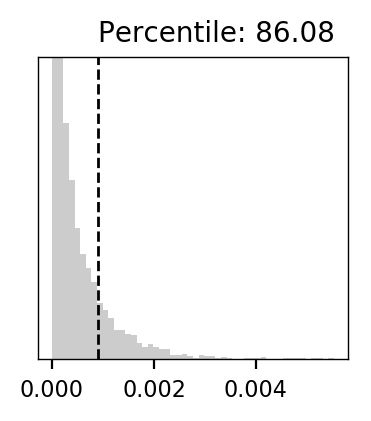

116


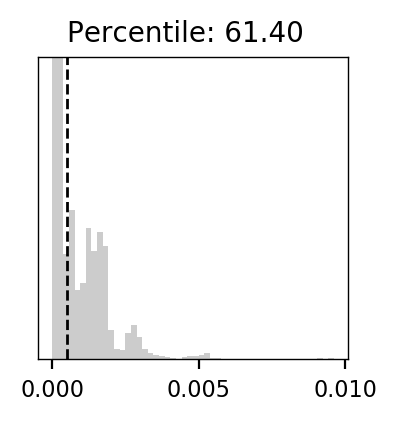

117


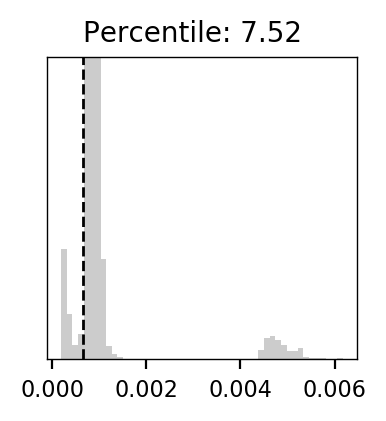

118


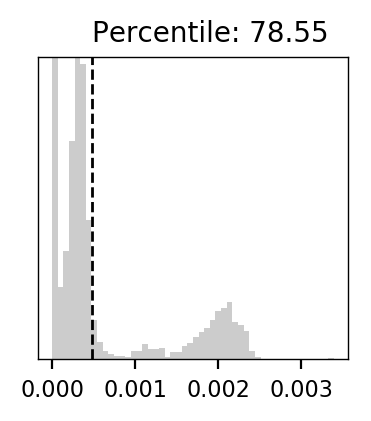

120


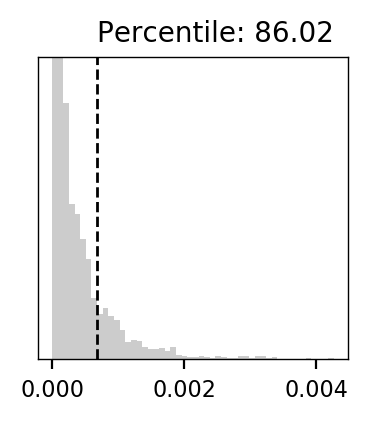

121


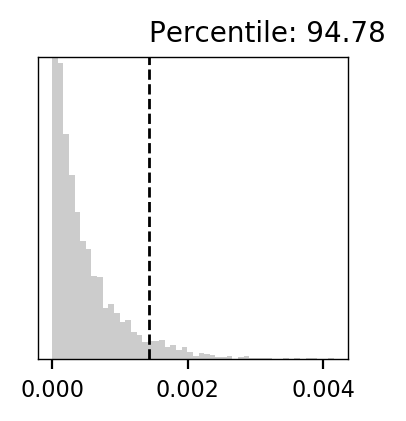

122


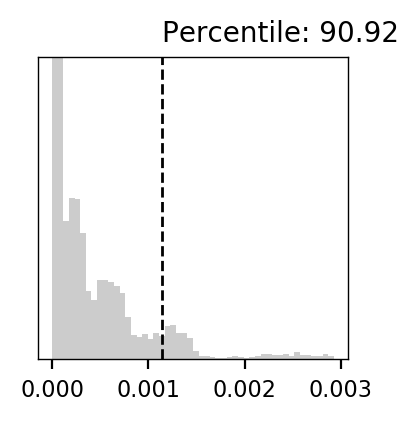

123


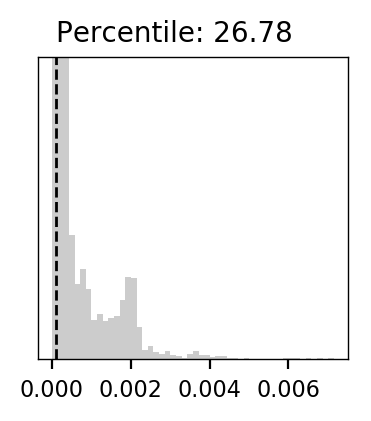

124


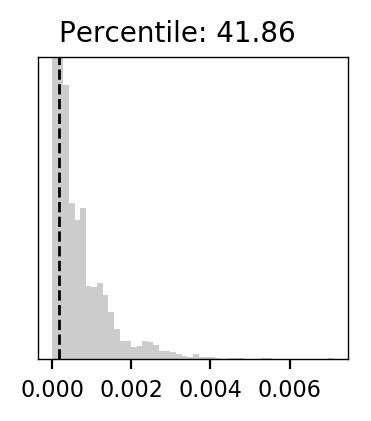

125


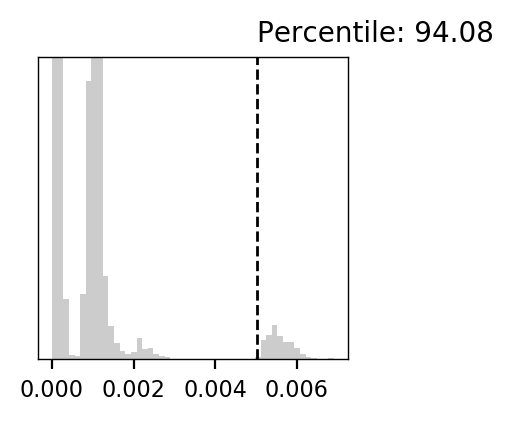

126


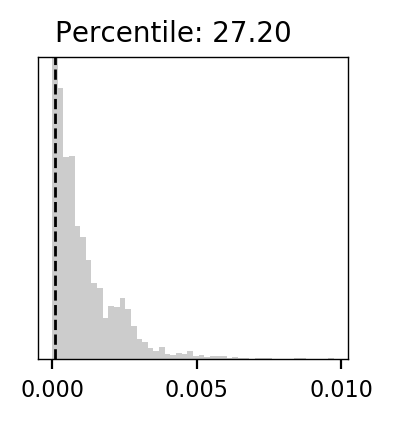

127


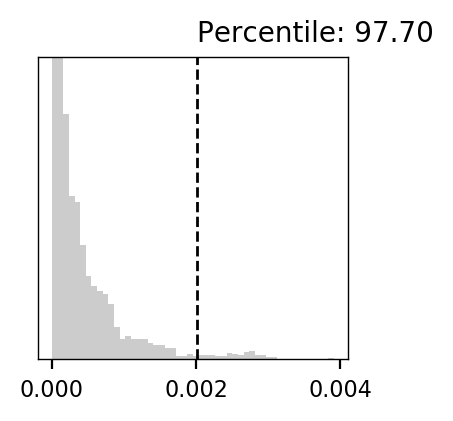

128


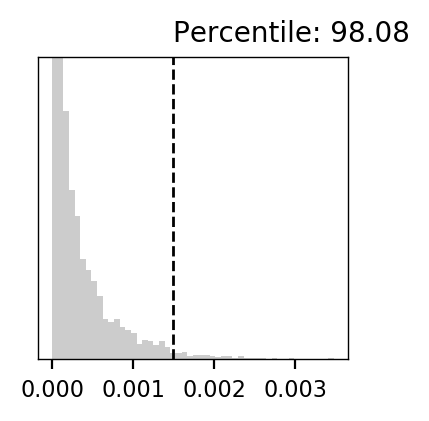

129


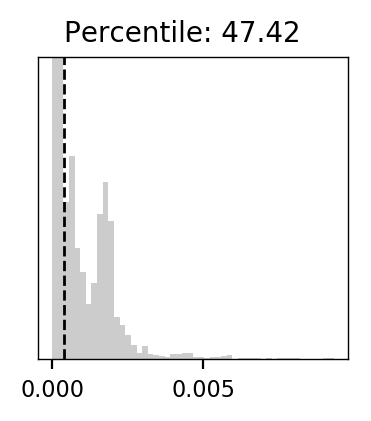

130


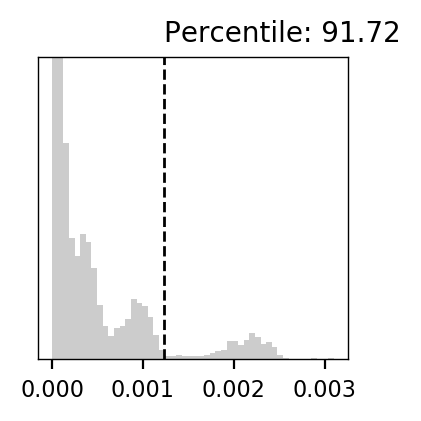

131


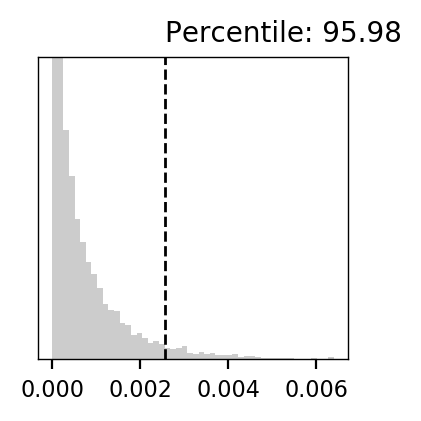

132


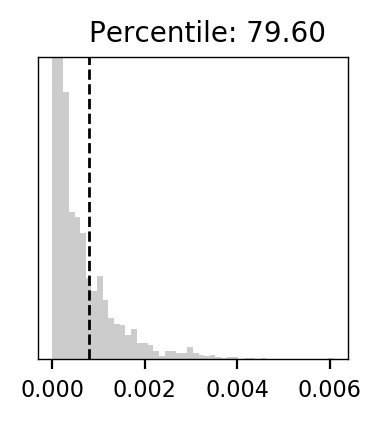

134


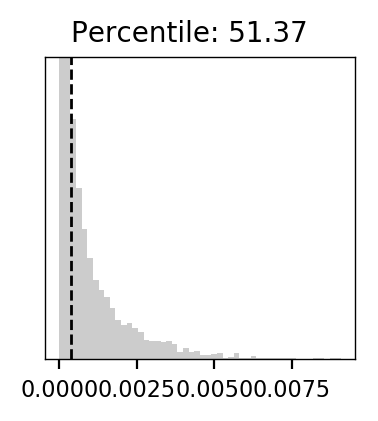

135


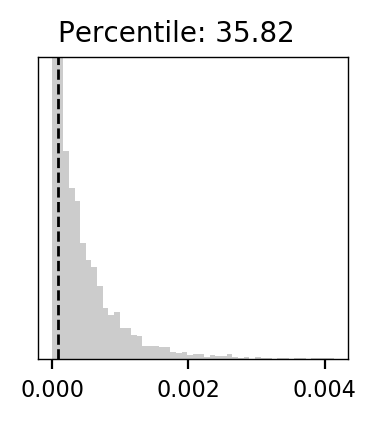

136


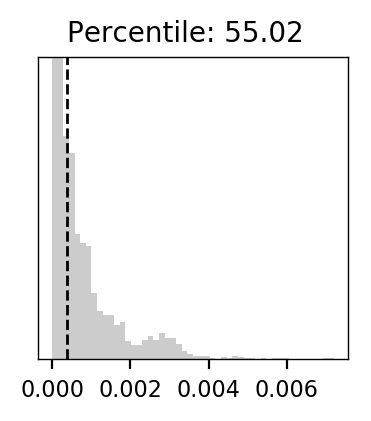

137


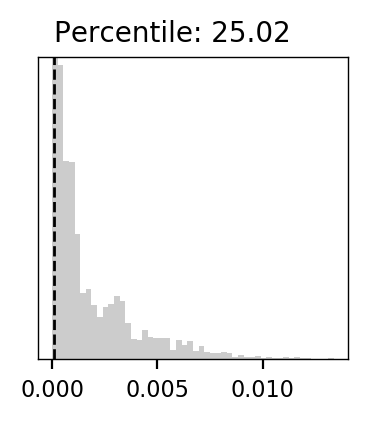

138


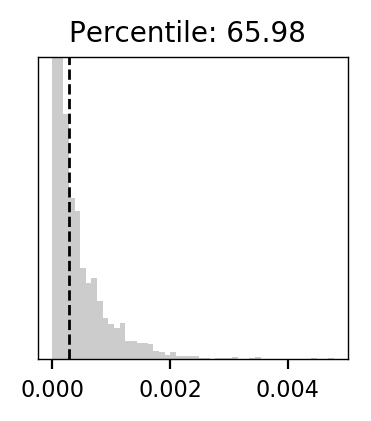

139


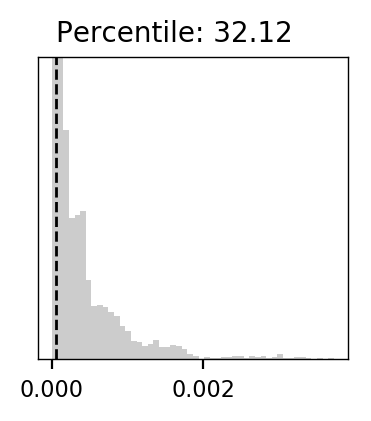

140


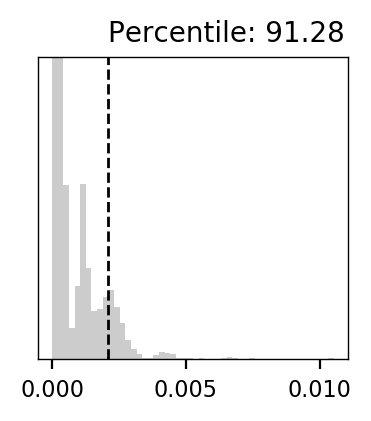

141


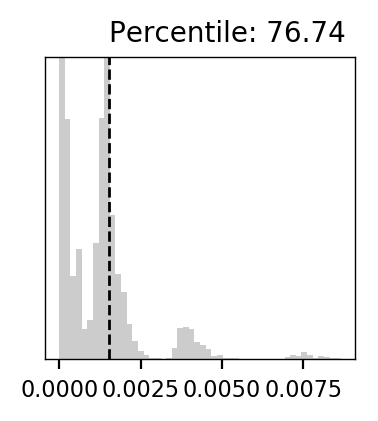

142


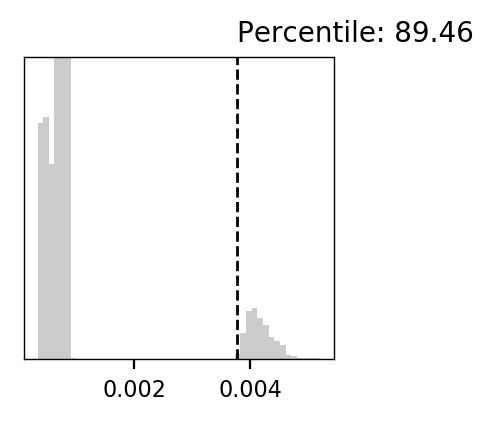

143


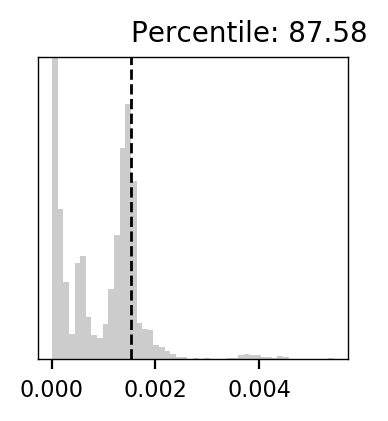

144


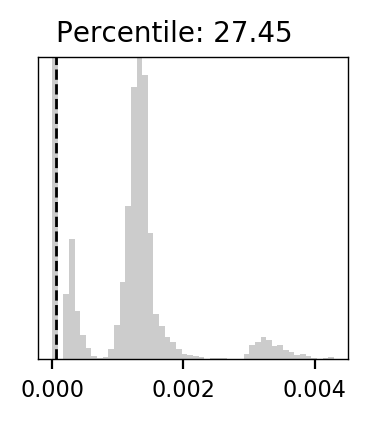

145


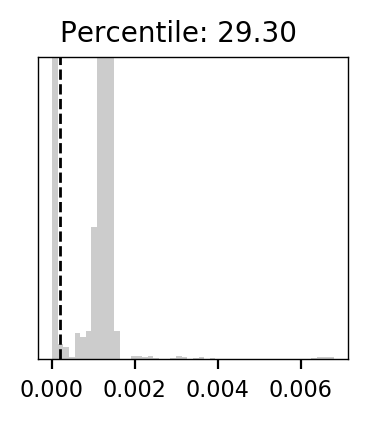

146


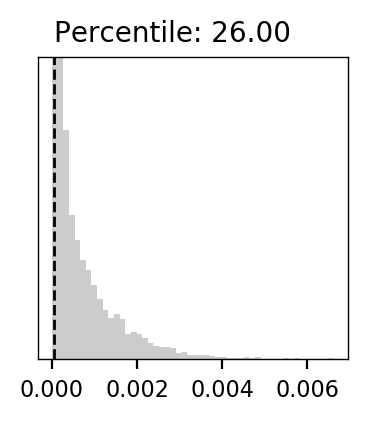

147


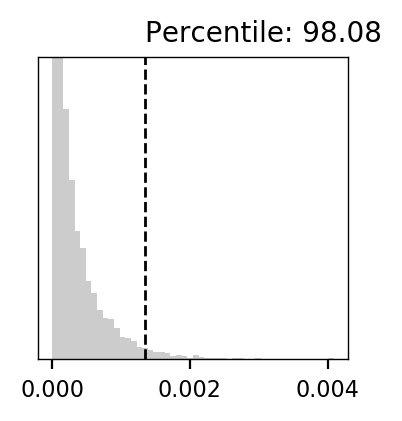

148


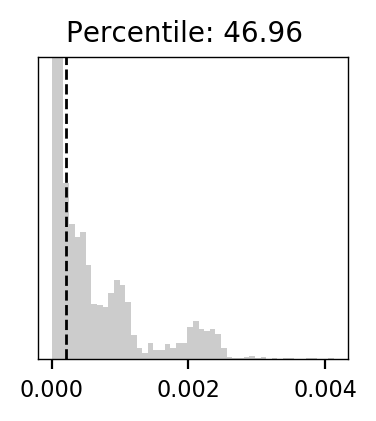

149


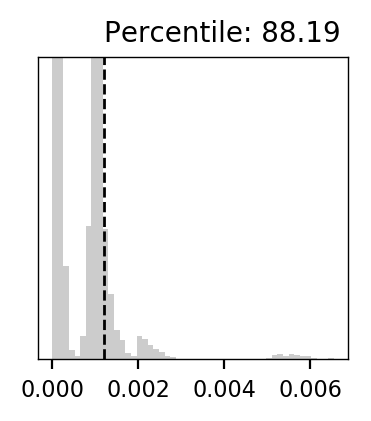

150


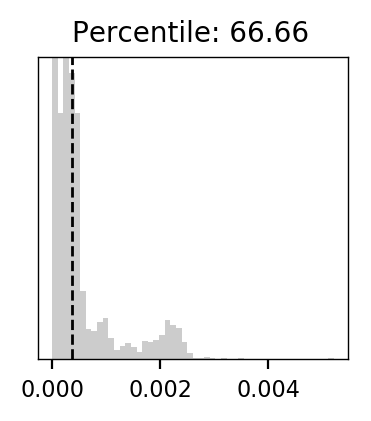

151


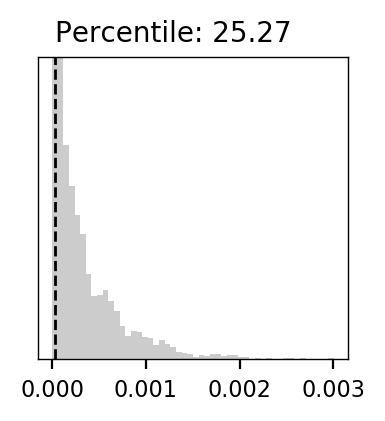

152


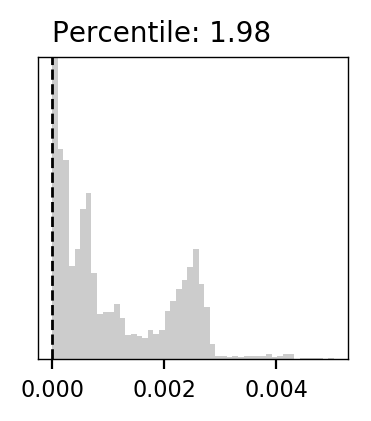

153


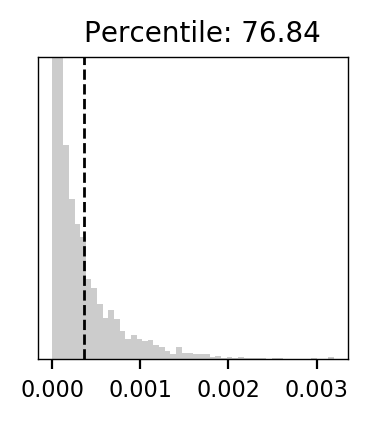

154


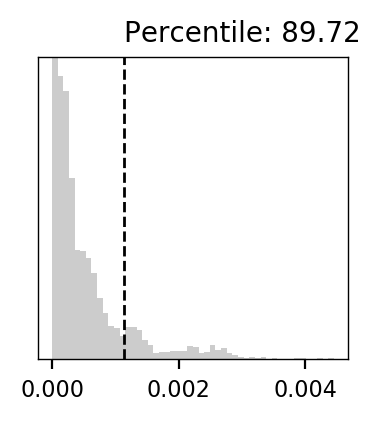

155


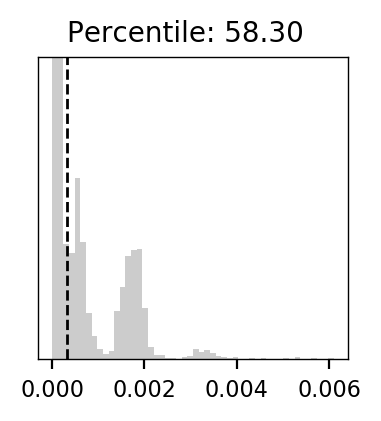

156


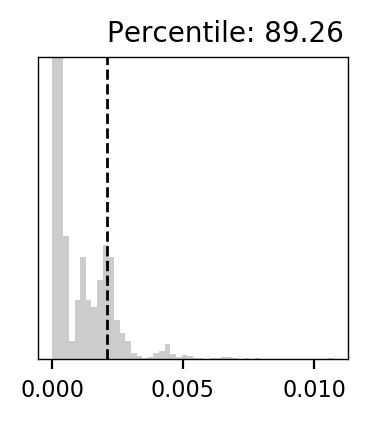

157


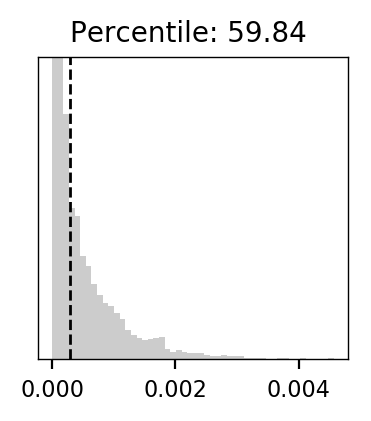

158


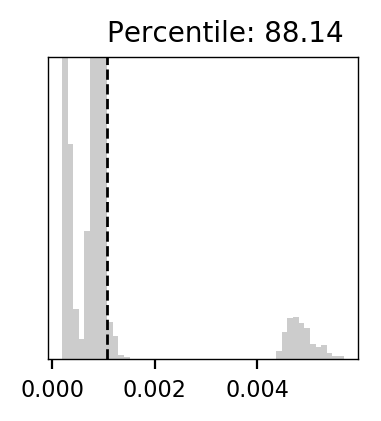

159


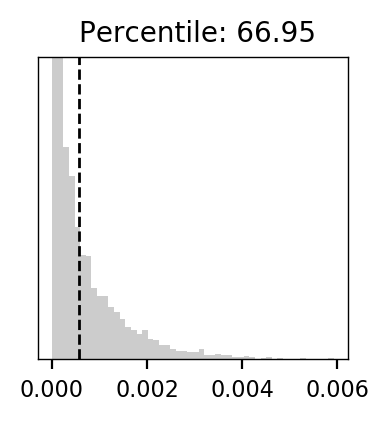

160


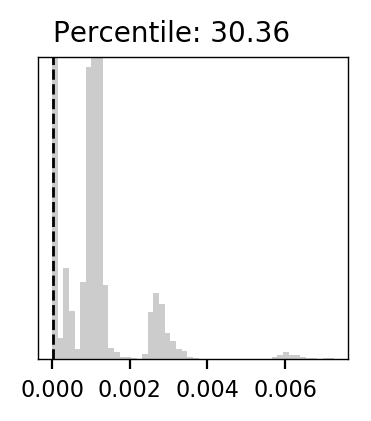

161


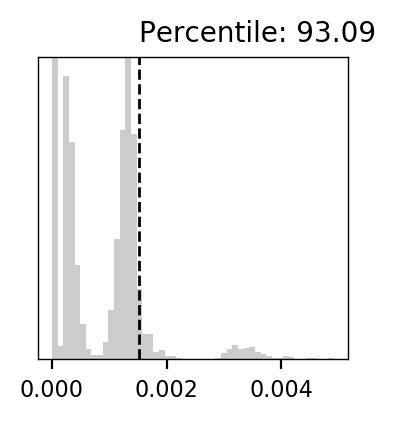

162


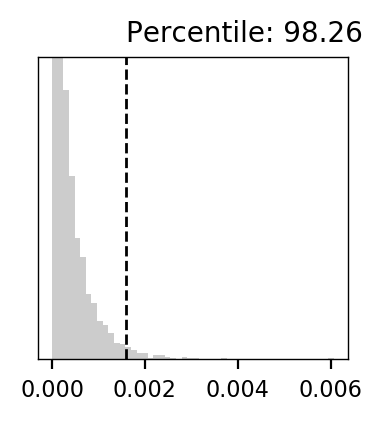

163


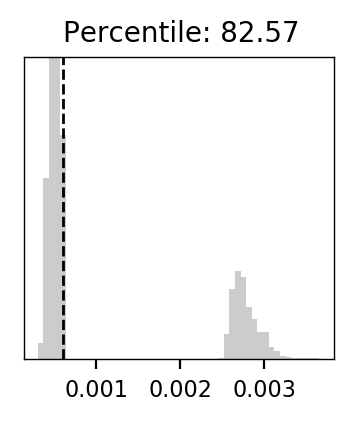

164


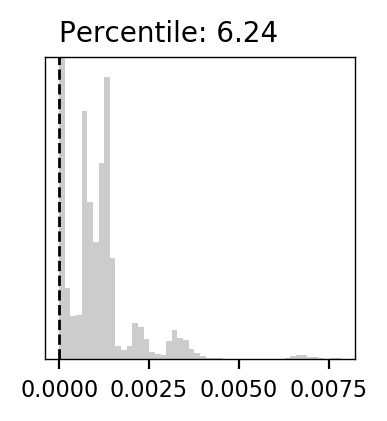

165


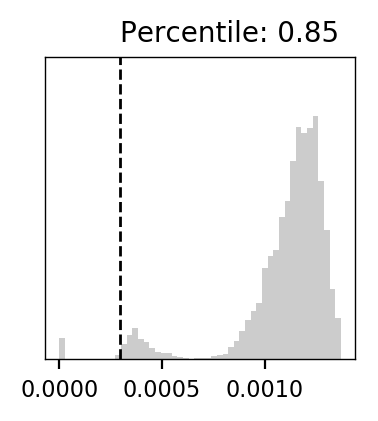

166


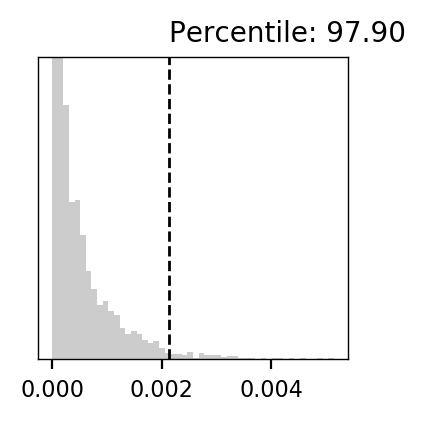

167


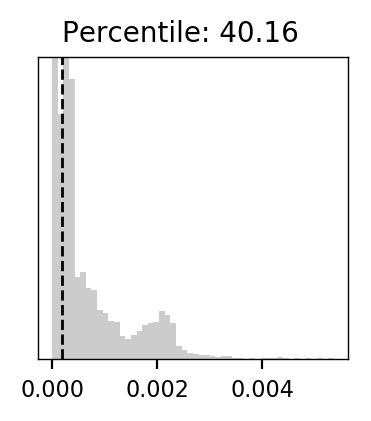

168


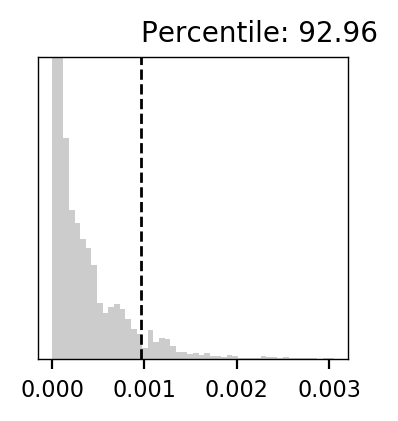

169


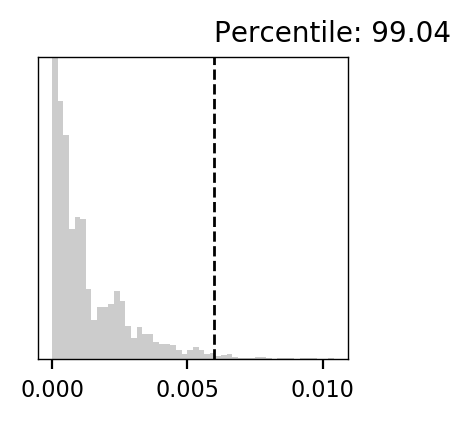

171


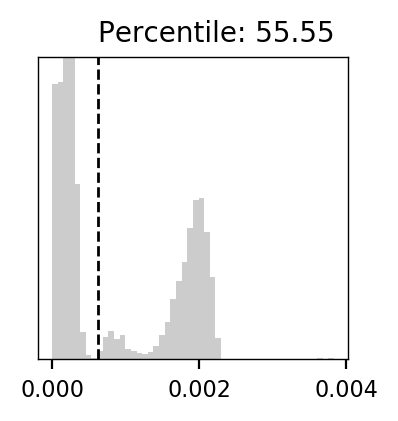

172


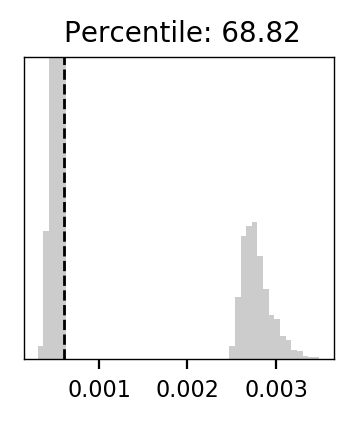

173


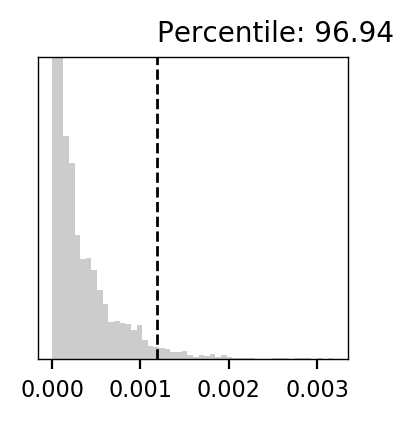

174


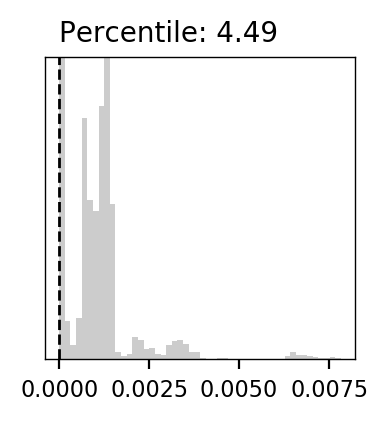

175


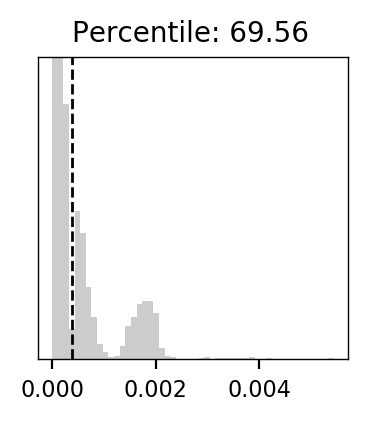

176


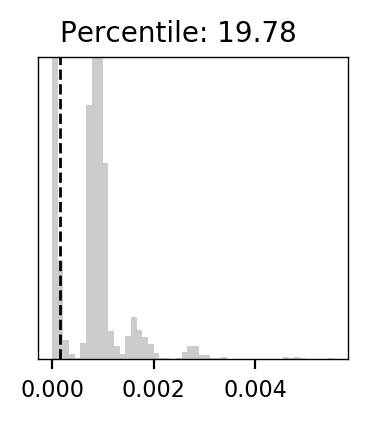

177


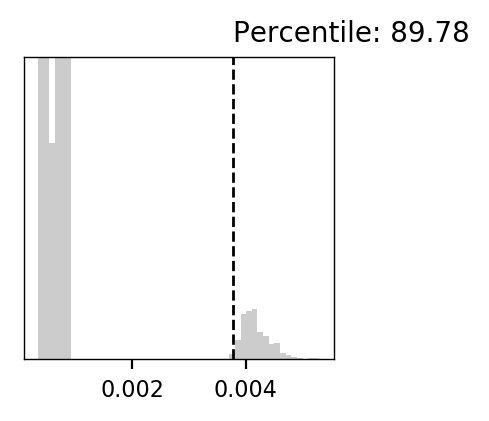

In [24]:
# for i in range(len(dist)):
#     if 99.17 > perc[i]:
#         print(i)


#         plt.figure(num=None, figsize=(2, 2), dpi=200, facecolor='w', edgecolor='k')
#         # plt.hist(dist[27], bins = 50, color = 'dodgerblue')

#         sns.distplot(dist[i], bins = 50,  color = 'gray', kde=False)
#         # sns.kdeplot(dist[27], shade=True, color = 'dodgerblue')

#         plt.axvline(similarity[i], color='k', linestyle='dashed', linewidth=1)
#         plt.ylim(0,600)
#         plt.tick_params(bottom=True, left=False, right=False, labelleft=False, labelbottom=True)

#         _, max_ = plt.ylim()
#         plt.text(similarity[i],
#                  max_ + max_/20, 
#                  'Percentile: {:.2f}'.format(perc[i]))


        
# #         plt.xlabel("Similarity")
# #         plt.ylabel("Number of occurence")
#         plt.show()